In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

rng = np.random.RandomState(42)



<h1>Data required for this project:</h1>
<ul>
<li>Property Price Distribution (Given)</li>
<li>Singapore Residents By Age Group, Ethnic Group And Sex, End June, Annual (Self Sourced)</li>
<li>Residents By Age Group & Type Of Dwelling, Annual (Self Sourced)</li>
<li>Indicators On Population, Annual (Self Sourced)</li>
</ul>

In [2]:
# population indicator df
# import data and transpose
population = pd.read_csv("./population_indicators.csv").transpose()
# select data up to the year 2000
population = population.loc[:'2000']
# Rename first row as columns
population = population.rename(columns = population.iloc[0]).drop(population.index[0])
# population = population.drop(population.columns[6:],axis=1)
population = population.applymap(lambda x: int(x.replace(',', '')) if not '.' in x else float(x))
# drop all column names with Ratio since they are collinear with the population data
# population = population[[x for x in list(
#     population.columns) if 'ratio' not in x.lower() and 'growth' not in x.lower() and 'age' not in x.lower() and 'natural' not in x.lower()]]
population.head()


,Total Population (Number),Resident Population (Number),Singapore Citizen Population (Number),Permanent Resident Population (Number),Non-Resident Population (Number),Total Population Growth (Per Cent),Resident Population Growth (Per Cent),Population Density (Total Population Per Square Kilometre),Sex Ratio (Males Per Thousand Females),Median Age Of Resident Population (Years),...,Old-Age Support Ratio: Citizens Aged 15-64 Years Per Citizen Aged 65 Years & Over (Number),Age Dependency Ratio: Citizens Aged Under 15 Years And 65 Years & Over Per Hundred Citizens Aged 15-64 Years (Number),Child Dependency Ratio: Citizens Aged Under 15 Years Per Hundred Citizens Aged 15-64 Years (Number),Old-Age Dependency Ratio: Citizens Aged 65 Years & Over Per Hundred Citizens Aged 15-64 Years (Number),Old-Age Support Ratio: Citizens Aged 20-64 Years Per Citizen Aged 65 Years & Over (Number),Age Dependency Ratio: Citizens Aged Under 20 Years And 65 Years & Over Per Hundred Citizens Aged 20-64 Years (Number),Child Dependency Ratio: Citizens Aged Under 20 Years Per Hundred Citizens Aged 20-64 Years (Number),Old-Age Dependency Ratio: Citizens Aged 65 Years & Over Per Hundred Citizens Aged 20-64 Years (Number),Natural Increase (Number),Rate Of Natural Increase (Per Thousand Residents)
2021,5453566,3986842,3498191,488651,1466724,-4.1,-1.4,7485,960,41.8,...,3.8,48.7,22.5,26.2,3.5,61.4,33.0,28.5,14431,2.7
2020,5685807,4044210,3523191,521019,1641597,-0.3,0.4,7810,957,41.5,...,4.1,46.8,22.2,24.6,3.7,59.7,32.9,26.8,16536,3.3
2019,5703569,4026209,3500940,525269,1677360,1.2,0.8,7866,957,41.1,...,4.3,45.2,22.0,23.2,4.0,58.4,33.1,25.3,17833,3.7
2018,5638676,3994283,3471936,522347,1644393,0.5,0.7,7804,959,40.8,...,4.6,43.7,21.9,21.8,4.2,57.0,33.2,23.8,17757,3.7
2017,5612253,3965796,3439177,526619,1646457,0.1,0.8,7796,961,40.5,...,4.9,42.5,21.9,20.6,4.4,56.2,33.7,22.6,18710,4.0


In [3]:
# dewlling df
# import data and transpose
dwellings = pd.read_csv("./dwellings.csv").transpose()
# make first row as columns
dwellings = dwellings.rename(
    columns=dwellings.iloc[0]).drop(dwellings.index[0])
# map values to int
dwellings = dwellings.applymap(lambda x: int(x.replace(',','')))
dwellings = dwellings.drop(['Residents'],axis=1)
dwellings.head()
# lets group the dewlling infomation by age groups


,Total HDB Dwellings,HDB 1- And 2-Room Flats,HDB 3-Room Flats,HDB 4-Room Flats,HDB 5-Room And Executive Flats,Condominiums & Other Apartments,Landed Properties,Other Types Of Dwelling,0-4 Years,Total HDB Dwellings,...,Other Types Of Dwelling,90 Years & Over,Total HDB Dwellings,HDB 1- And 2-Room Flats,HDB 3-Room Flats,HDB 4-Room Flats,HDB 5-Room And Executive Flats,Condominiums & Other Apartments,Landed Properties,Other Types Of Dwelling
2021,3090959,179559,557100,1312346,1041954,620246,240841,34796,178435,138502,...,2370,22090,15440,1736,4147,5632,3925,1363,2613,2674
2020,3152410,177358,575200,1338374,1061478,607937,248860,35003,183076,144145,...,2310,20875,14636,1655,3890,5346,3745,1255,2453,2531
2019,3154524,173771,580233,1337743,1062777,587860,249077,34748,185355,146195,...,2080,19429,13540,1569,3570,4898,3503,1187,2271,2431
2018,3149249,170955,584821,1331440,1062033,562228,248240,34566,185528,147012,...,2019,17786,12414,1449,3262,4463,3240,1094,2080,2198
2017,3156575,168052,590806,1330160,1067557,525584,249408,34229,187653,150516,...,1910,16454,11462,1345,3041,4140,2936,1037,1916,2039


<p>
It is common in demography to split the population into three broad age groups:
<ul>
<li>children and young adolescents (under 15 years old)
<li>the working-age population (15-64 years) and.
<li>the elderly population (65 years and older)
</ul>
</p>
Source: <a>https://ourworldindata.org/age-structure</a>


In [4]:
# save the column index range for children, adult and elderly data
dwellingsAgeGroupColumns = list(dwellings.columns)[8:]
dwellingAgeGroupArr = {'Children': [],
                       'Adult': [], 'Elderly': []}
for i in range(len(list(dwellings.columns))//9):
    a = dwellingsAgeGroupColumns[i*9:i*9+9]
    if '-' in a[0][:2] or a[0][:2] < '15':
        dwellingAgeGroupArr['Children'].append([8+i*9,8+i*9+9])
    elif a[0][:2] < '65':
        dwellingAgeGroupArr['Adult'].append([8+i*9, 8+i*9+9])
    else:
        dwellingAgeGroupArr['Elderly'].append([8+i*9,8+i*9+9])


In [5]:
premadeColumnNames = ['_Dwellers', '_Total HDB Dwellings', '_HDB 1 And 2 Room Flats',   '_HDB 3-Room Flats',	  '_HDB 4-Room Flats',
                      '_HDB 5-Room And Executive Flats',   '_Condominiums & Other Apartments',   '_Landed Properties',   '_Other Types Of Dwelling']


def sumColumns(group):
    dummy = pd.DataFrame({})
    for rg in dwellingAgeGroupArr[group]:
        df = dwellings.iloc[:, rg[0]:rg[1]].copy()
        df.columns = premadeColumnNames
        if dummy.empty:
            dummy = df
        else:
            dummy += df
        # print(dwellings.iloc[:,rg[0]:rg[1]])
    dummy.columns = [f'{group}{x}' for x in list(dummy.columns)]
    return dummy
    
# sum these data together and form 1 dataFrame
dwellingsByAgeGroup = pd.concat(
    [sumColumns('Children'), sumColumns('Adult'), sumColumns('Elderly')], axis=1)
dwellingsByAgeGroup.head()

,Children_Dwellers,Children_Total HDB Dwellings,Children_HDB 1 And 2 Room Flats,Children_HDB 3-Room Flats,Children_HDB 4-Room Flats,Children_HDB 5-Room And Executive Flats,Children_Condominiums & Other Apartments,Children_Landed Properties,Children_Other Types Of Dwelling,Adult_Dwellers,...,Adult_Other Types Of Dwelling,Elderly_Dwellers,Elderly_Total HDB Dwellings,Elderly_HDB 1 And 2 Room Flats,Elderly_HDB 3-Room Flats,Elderly_HDB 4-Room Flats,Elderly_HDB 5-Room And Executive Flats,Elderly_Condominiums & Other Apartments,Elderly_Landed Properties,Elderly_Other Types Of Dwelling
2021,577188,425749,22955,55975,191418,155401,118271,31296,1872,2770646,...,16516,639008,516327,49856,127231,196767,142473,53813,52460,16408
2020,588206,440318,22918,60629,197746,159025,114460,31325,2103,2841636,...,17076,614368,495212,47395,123935,188040,135842,51756,51576,15824
2019,591056,445622,22900,63091,198448,161183,111735,31538,2161,2853473,...,17436,581680,468794,44547,119547,177189,127511,48242,49493,15151
2018,591124,450566,23322,64978,197989,164277,106746,31471,2341,2855305,...,17779,547854,441018,41773,114477,166071,118697,45113,47277,14446
2017,594481,461039,23779,67293,199711,170256,99011,31918,2513,2854623,...,18448,516692,416206,38987,109977,156073,111169,41694,45524,13268


In [6]:
populationDf = pd.concat(
    [population, dwellingsByAgeGroup], axis=1)
populationDf.index = populationDf.index.astype('int64')
print(
    f'Number of rows with missing values: {populationDf.isnull().any(axis=1).mean()}')
populationFeatures = list(populationDf.columns)
populationFeatures = [
    x for x in populationFeatures if 'Residents' not in x and '_Dwellers' not in x]
populationFeatures = [
    x for x in populationFeatures if 'Residents' not in x and '_Dwellers' not in x]
populationDf = populationDf[populationFeatures]


Number of rows with missing values: 0.0


In [7]:
populationDf.shape

(22, 44)

In [9]:
resale_data = pd.read_csv('./train.csv')

In [10]:
# since we are looking at the trend of property price, independent variables are sold year, flat type, dependent variable is resale price/sqm
resale_data.head()

,town,lat,lng,month,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,GEYLANG,NaN,NaN,2006-01-01,4 ROOM,328,UBI AVE 1,04 TO 06,84.0,Simplified,1985.0,175000.0,NaN
1,JURONG EAST,NaN,NaN,2003-02-01,5 ROOM,271,TOH GUAN RD,10 TO 12,120.0,Improved,1999.0,353000.0,NaN
2,TOA PAYOH,NaN,NaN,2005-09-01,3 ROOM,205,TOA PAYOH NTH,10 TO 12,65.0,Improved,1973.0,215000.0,NaN
3,PASIR RIS,NaN,NaN,2001-03-01,EXECUTIVE,508,PASIR RIS ST 52,04 TO 06,146.0,Apartment,1993.0,482000.0,NaN
4,JURONG WEST,NaN,NaN,2014-07-01,EXECUTIVE,656B,JURONG WEST ST 61,10 TO 12,133.0,Apartment,2001.0,613000.0,NaN


In [11]:
# def classifyModel(model):
#     if 'Maisonette' in model or 'Generation' in model:
#         return 'Maisonette'
#     elif 'Type' in model:
#         return 'Type'
#     elif 'Model' in model:
#         return 'Model'
#     elif 'Apartment' in model:
#         return 'Apartment'
#     else:
#         return model

resaledf = resale_data[['flat_type', 'month',
                            'floor_area_sqm', 'resale_price']].copy()
resaledf['month'] = pd.to_datetime(resaledf['month'])
resaledf['year_sold'] = resaledf['month'].dt.strftime(
    '%Y').astype('int64')
resaledf['price_per_sqm'] = resaledf['resale_price'] / \
    resaledf['floor_area_sqm']
resaledf = resaledf[resaledf['year_sold'] <=2021]
resaledf.drop(['month', 'floor_area_sqm',
                  'resale_price'], axis=1, inplace=True)
resaledf = resaledf.groupby(['year_sold', 'flat_type']).mean()
resaledf=resaledf.reset_index(level=[0,1])
resaledf=resaledf.pivot('year_sold','flat_type','price_per_sqm')
resaledf.index.name = 'year'


In [12]:
resaledf.shape

(22, 7)

In [13]:
resaledf.tail()

flat_type,1 ROOM,2 ROOM,3 ROOM,4 ROOM,5 ROOM,EXECUTIVE,MULTI-GENERATION
year,,,,,,,
2017,6451.612903,5305.176390,4663.605988,4597.880033,4515.281672,4345.293777,4633.648474
2018,5955.645161,5191.575080,4489.682402,4547.854825,4496.140893,4368.649129,4990.765586
2019,5646.121864,4975.987474,4403.845822,4541.559182,4463.029835,4261.466360,4978.977304
2020,5766.129032,5061.122570,4600.731557,4762.983781,4637.009580,4379.491499,4844.669788
2021,6362.007168,5805.785281,5181.415324,5377.000976,5162.393626,4875.930048,5301.695349


Text(0.5, 1.0, 'Resale Property Price trend from 2000 to 2020')

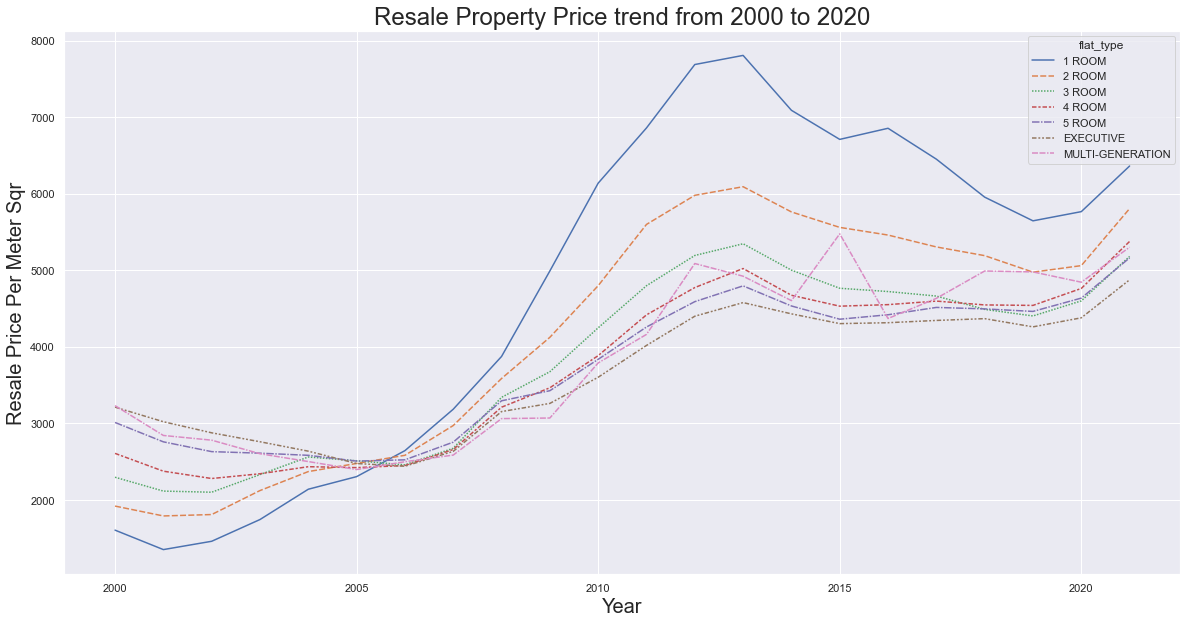

In [14]:
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf)
p.set_ylabel('Resale Price Per Meter Sqr',fontsize=20)
p.set_xlabel('Year',fontsize=20)
p.set_title('Resale Property Price trend from 2000 to 2020', fontsize=24)

In [15]:
# Standize both index to timeseries with frequecy of Month
# join population dataset with resale df
joinDf = resaledf.join(populationDf,how='inner')
# convert index to timeseries
joinDf.index = pd.to_datetime(joinDf.index, format='%Y')

# add freq to datetime
joinDf=joinDf.asfreq('MS')
joinDf=joinDf.interpolate()
joinDf = joinDf.applymap(lambda x:int(x))
populationDf = joinDf[populationDf.columns.to_list()]
resaledf = joinDf[resaledf.columns.to_list()]


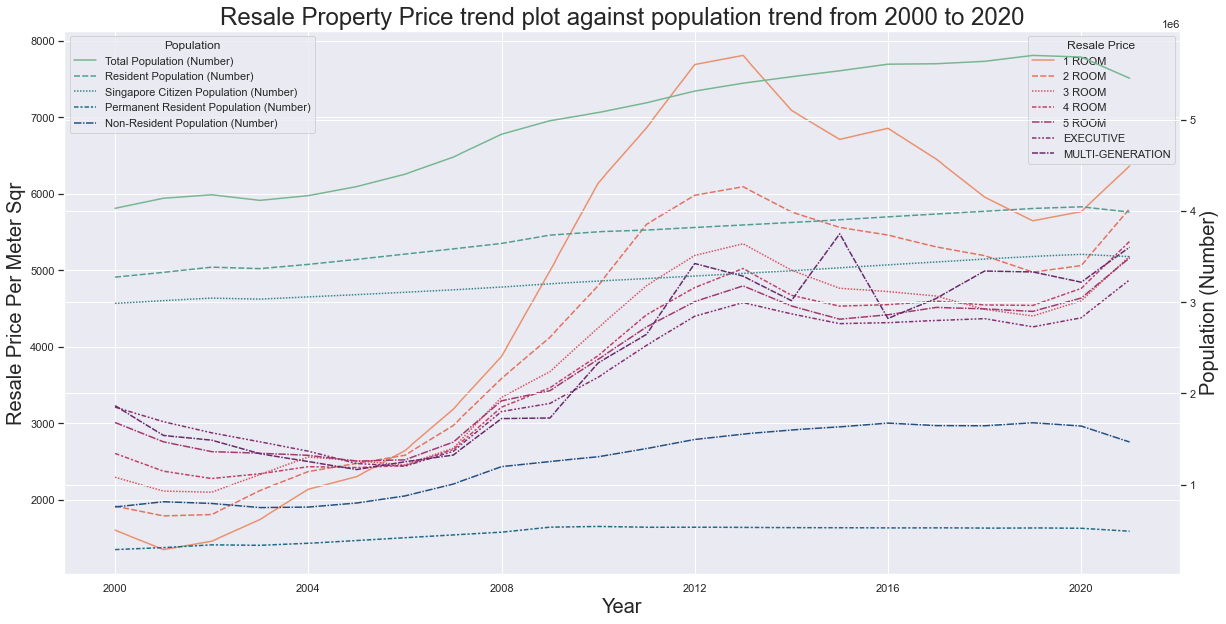

In [16]:
# plot resale price vs population size
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title('Resale Property Price trend plot against population trend from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf.iloc[:,:5], ax=ax2, palette='crest')
q.set_ylabel('Population (Number)',fontsize=20)
q.legend(loc='upper left', title="Population")


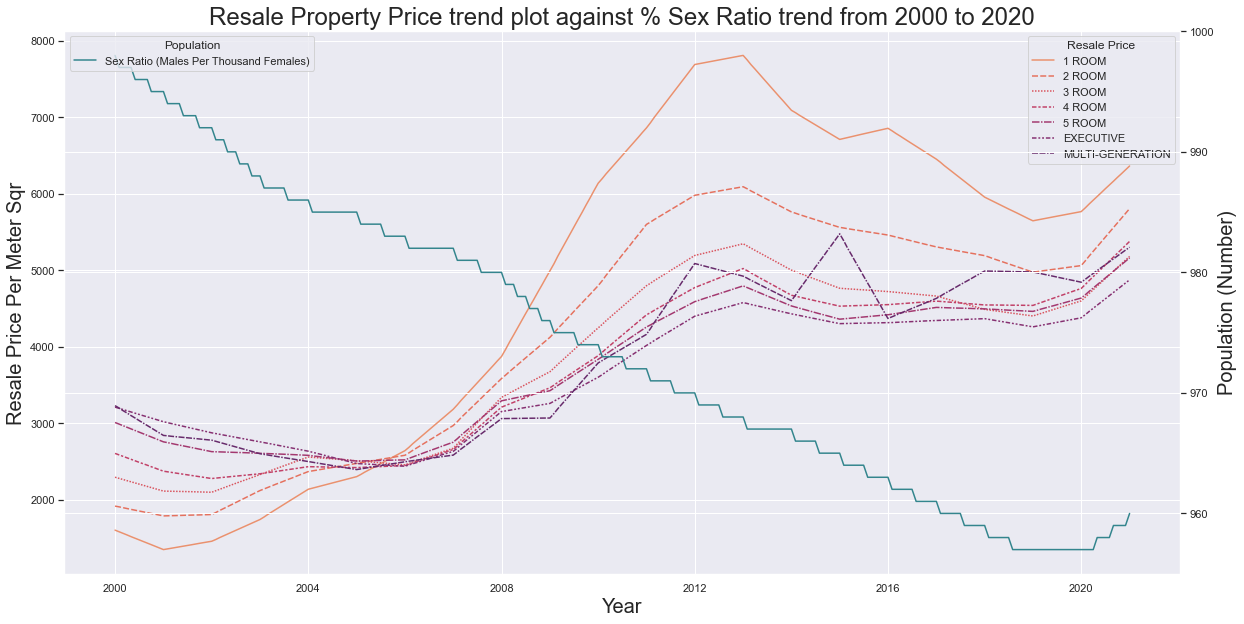

In [25]:
# plot resale price vs population size
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title(
    'Resale Property Price trend plot against % Sex Ratio trend from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf.iloc[:, 8:9], ax=ax2, palette='crest')
q.set_ylabel('Population (Number)', fontsize=20)
q.legend(loc='upper left', title="Population")


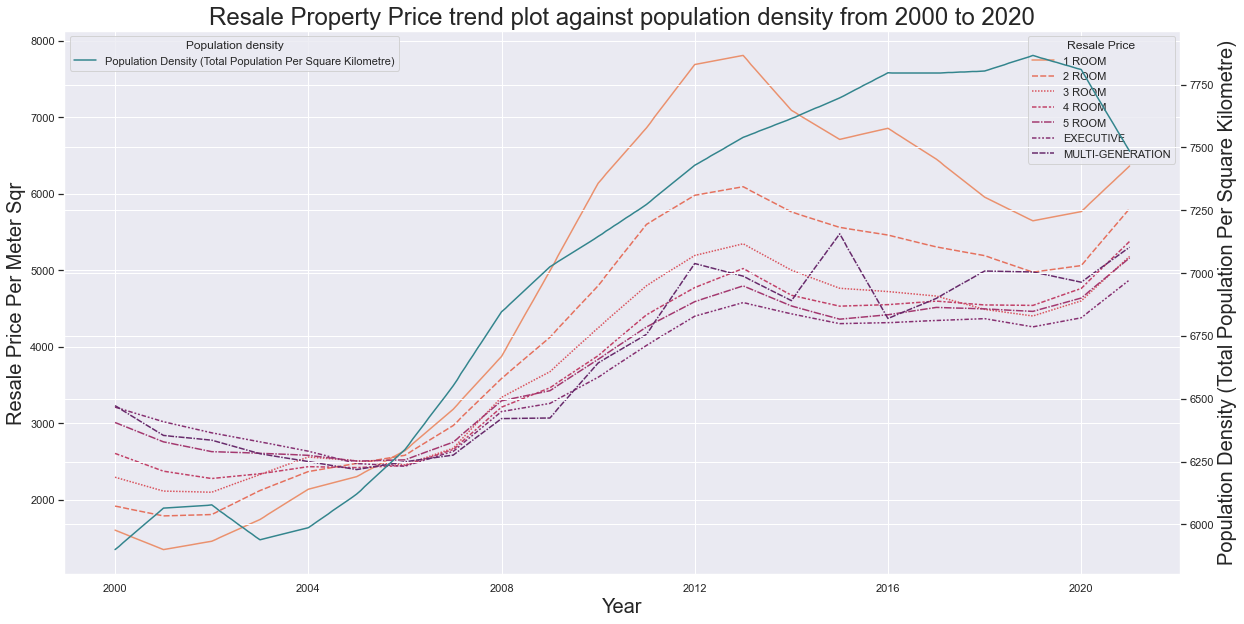

In [64]:
# plot resale price vs population density
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title(
    'Resale Property Price trend plot against population density from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf.iloc[:, 5:6], ax=ax2, palette='crest')
q.set_ylabel(
    'Population Density (Total Population Per Square Kilometre)', fontsize=20)
q.legend(loc='upper left', title="Population density")


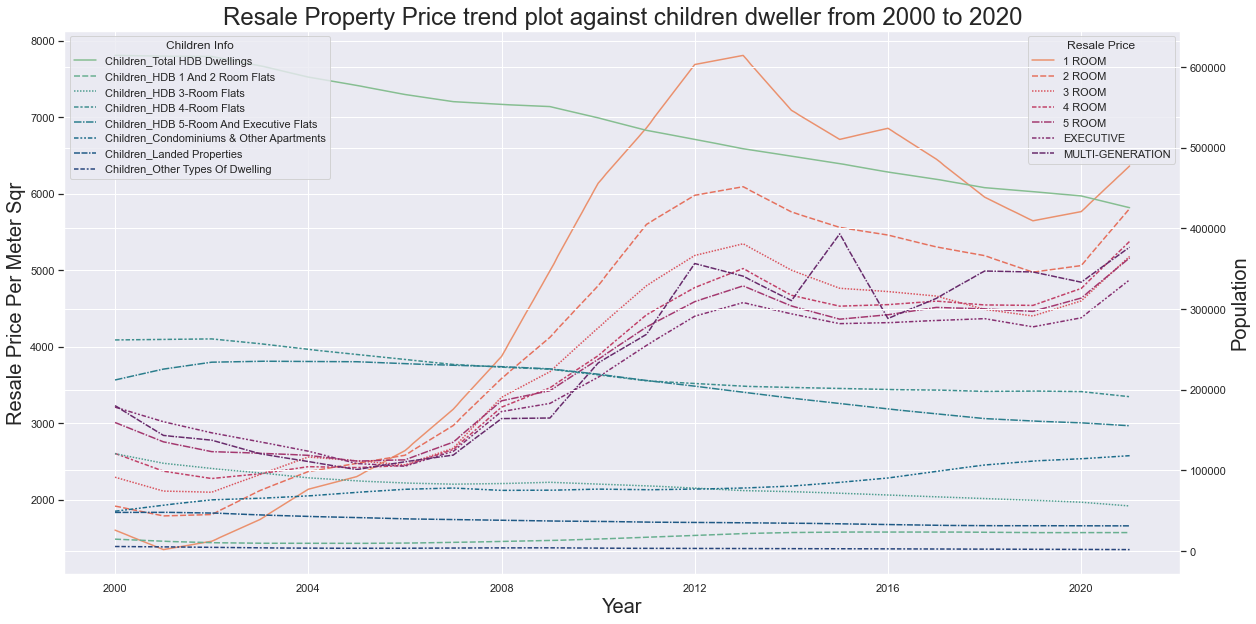

In [65]:
# plot resale price vs children population and dweller info
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title(
    'Resale Property Price trend plot against children dweller from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf[[x for x in list(
    populationDf.columns) if 'Children' in x]], ax=ax2, palette='crest')
q.set_ylabel('Population', fontsize=20)
q.legend(loc='upper left', title="Children Info")


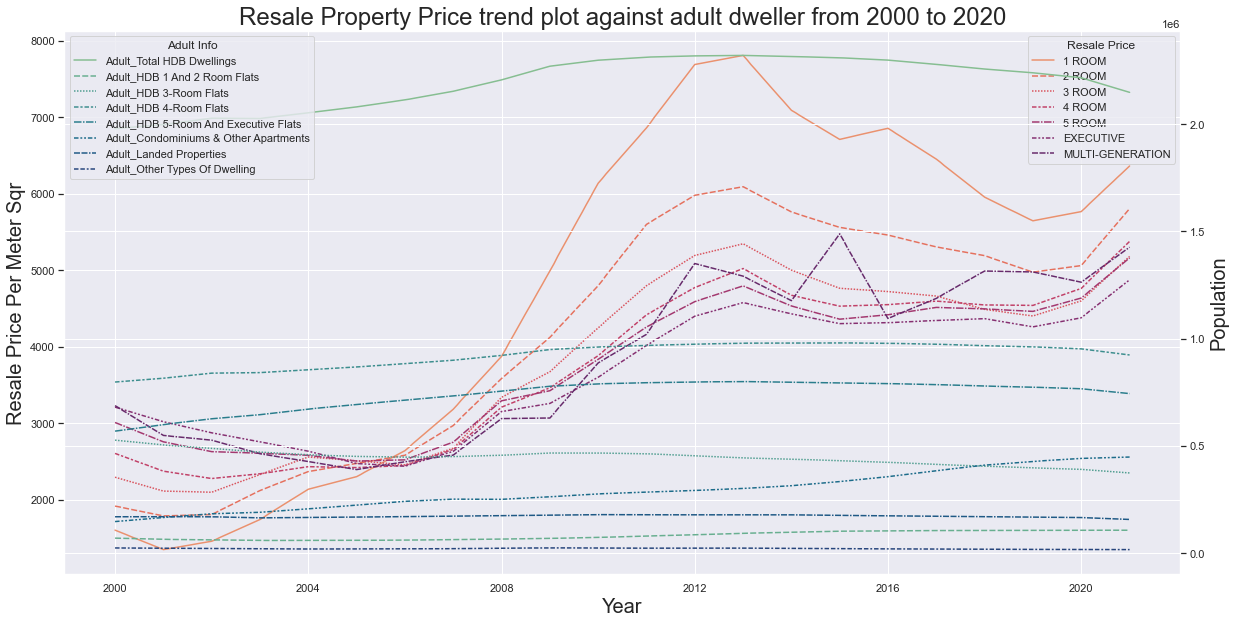

In [66]:
# plot resale price vs adult population and dweller info
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title(
    'Resale Property Price trend plot against adult dweller from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf[[x for x in list(
    populationDf.columns) if 'Adult' in x]], ax=ax2, palette='crest')
q.set_ylabel('Population', fontsize=20)
q.legend(loc='upper left', title="Adult Info")


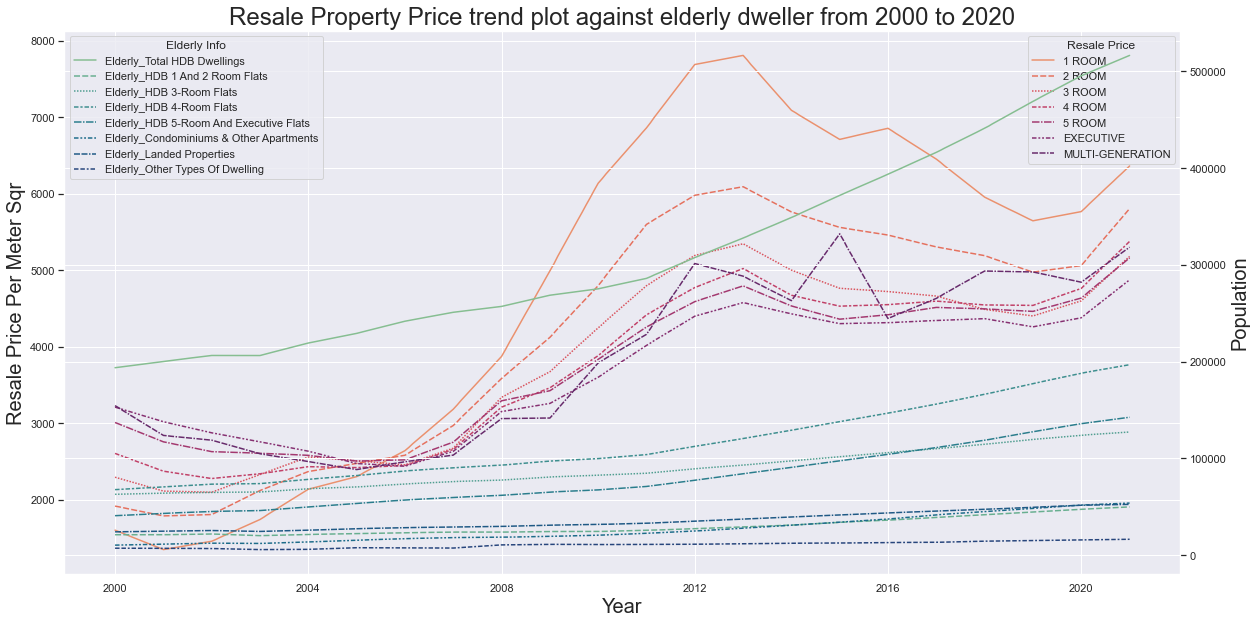

In [67]:
# plot resale price vs elderly population and dweller info
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title(
    'Resale Property Price trend plot against elderly dweller from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf[[x for x in list(
    populationDf.columns) if 'Elderly' in x]], ax=ax2, palette='crest')
q.set_ylabel('Population', fontsize=20)
q.legend(loc='upper left', title="Elderly Info")


In [68]:
# piplines
# since all the independent are numeric and they are largely differ in value, standard scaling is required

ct = make_column_transformer(
    (Pipeline([
        ('scaler', StandardScaler()),
    ]),
        make_column_selector(dtype_include=np.number)),
)

ct.fit(populationDf)
transformed_populationDf = pd.DataFrame(ct.transform(populationDf), columns=populationFeatures)
transformed_populationDf.index = populationDf.index
transformed_populationDf=transformed_populationDf.sort_index()
resaledf=resaledf.sort_index()
# combine with Y variables -> resale data set
data = resaledf.join(transformed_populationDf, how='inner')
# convert index to timeseries
data.head()

,1 ROOM,2 ROOM,3 ROOM,4 ROOM,5 ROOM,EXECUTIVE,MULTI-GENERATION,Total Population (Number),Resident Population (Number),Singapore Citizen Population (Number),...,Adult_Landed Properties,Adult_Other Types Of Dwelling,Elderly_Total HDB Dwellings,Elderly_HDB 1 And 2 Room Flats,Elderly_HDB 3-Room Flats,Elderly_HDB 4-Room Flats,Elderly_HDB 5-Room And Executive Flats,Elderly_Condominiums & Other Apartments,Elderly_Landed Properties,Elderly_Other Types Of Dwelling
2000-01-01,1606,1920,2297,2608,3012,3212,3232,-1.601671,-1.836744,-1.559933,...,-0.504637,1.394275,-1.246737,-0.953619,-1.311476,-1.250980,-1.282177,-1.223557,-1.245027,-1.108974
2000-02-01,1585,1910,2282,2589,2991,3197,3200,-1.586266,-1.818559,-1.544517,...,-0.496154,1.344796,-1.241014,-0.953848,-1.306010,-1.244647,-1.275405,-1.216569,-1.238331,-1.110893
2000-03-01,1564,1899,2267,2570,2970,3181,3167,-1.570862,-1.800374,-1.529094,...,-0.487670,1.295316,-1.235280,-0.954076,-1.300494,-1.238314,-1.268600,-1.209505,-1.231523,-1.112812
2000-04-01,1543,1888,2252,2550,2949,3165,3135,-1.555457,-1.782190,-1.513677,...,-0.479187,1.245836,-1.229546,-0.954305,-1.295028,-1.231955,-1.261794,-1.202441,-1.224827,-1.114731
2000-05-01,1521,1877,2237,2531,2928,3149,3102,-1.540052,-1.764001,-1.498255,...,-0.470703,1.196356,-1.223823,-0.954533,-1.289512,-1.225622,-1.254989,-1.195377,-1.218020,-1.116331


In [69]:
# train test split use first 15 years to train, last 6 years as prediction
start_train = '2000-01-01'
end_train = '2014-12-01'
start_test = '2015-01-01'
end_test = '2021-01-01'
targets = resaledf.columns.to_list()

# 3 sets of data to valid
# 1 population data
# 2 population density data
# 3 dweller data (children adult elderly)

result = {}

In [70]:
def backtrackingForecast(target, exog=None, features=''):
    x = data[target]
    lags = 10
    forecaster = ForecasterAutoreg(
        regressor=LGBMRegressor(random_state=rng),
        lags=lags
    )

    if type(exog) == pd.core.frame.DataFrame:

        metric, predictions = backtesting_forecaster(
            forecaster=forecaster,
            y=x.loc[start_train:],
            exog=exog.loc[start_train:],
            initial_train_size=len(data.loc[start_train:end_train]),
            fixed_train_size=True,
            steps=1,
            refit=True,
            metric='mean_absolute_error',
            verbose=False,
        )

    else:
        metric, predictions = backtesting_forecaster(
            forecaster=forecaster,
            y=x.loc[start_train:],
            initial_train_size=len(data.loc[start_train:end_train]),
            fixed_train_size=True,
            steps=1,
            refit=True,
            metric='mean_absolute_error',
            verbose=False,
        )


    fig, ax = plt.subplots(figsize=(11, 4.5))
    x.loc[end_train:].plot(ax=ax, linewidth=2, label='Test')

    # Plot test predictions for different lags
    predictions = predictions.rename(
        columns={'pred': f'Prediction, {lags} lags'})
    predictions.plot(ax=ax, linewidth=2)

    ax.set_title(
        f'{target} resale price vs Predictions (Test Data) ({features})')
    ax.set_ylabel('Population')
    ax.set_xlabel('Year')
    ax.legend()
    plt.show()

    print('test_error: ',metric)

    result[features]=[metric,predictions]
    return metric, predictions


Forecaster will be fit 73 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



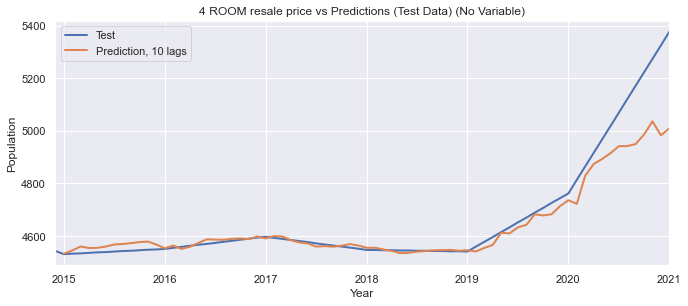

test_error:  38.76975046290385


In [71]:
# backtracking prediction without supporting data
# we look at 4 rooms flat since it is the most demanded property type in singapore
target = '4 ROOM'

metric, predictions = backtrackingForecast(target,features='No Variable')


Forecaster will be fit 73 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



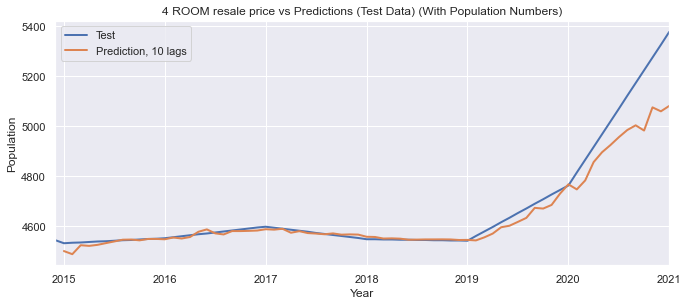

test_error:  33.751512064923666


In [72]:
# adding population number data as independent param
popData = data.loc[:,
                   'Total Population (Number)':'Non-Resident Population (Number)']
metric, predictions = backtrackingForecast(target, exog=popData, features='With Population Numbers')


Forecaster will be fit 73 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



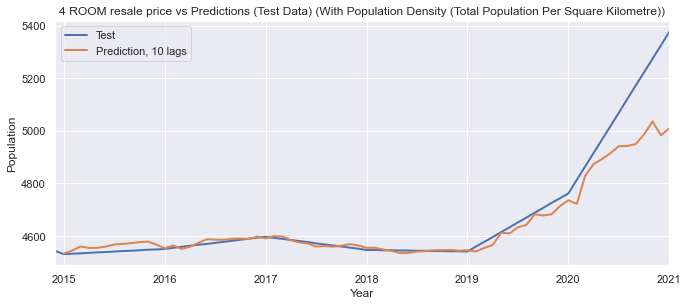

test_error:  38.76975046290385


In [73]:
# adding population density data as independent param
target = '4 ROOM'
d = data.loc[:,
             'Population Density (Total Population Per Square Kilometre)']
metric, predictions = backtrackingForecast(
    target, exog=d, features='With Population Density (Total Population Per Square Kilometre)')


Forecaster will be fit 73 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



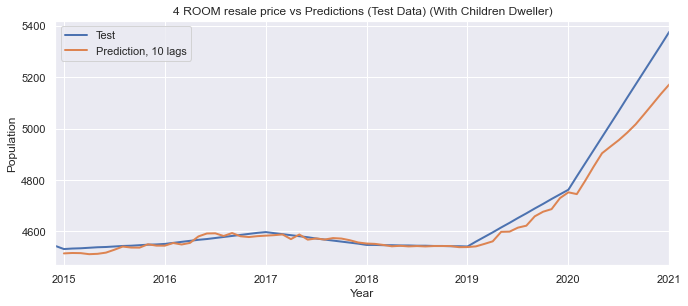

test_error:  30.82325990466981


In [74]:
# adding child dweller data as independent param
target = '4 ROOM'
d = data[[x for x in data.columns.to_list() if 'Children_' in x]]
metric, predictions = backtrackingForecast(
    target, exog=d, features='With Children Dweller')


Forecaster will be fit 73 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



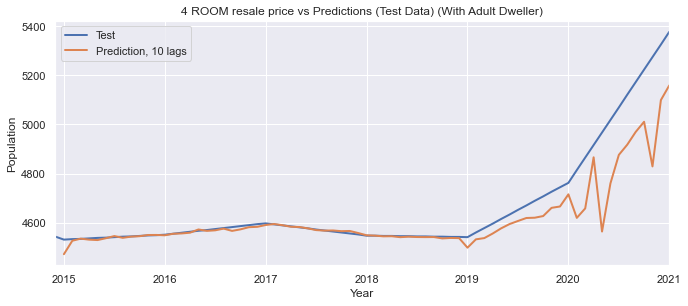

test_error:  50.97307500163423


In [75]:
# adding Adult dweller data as independent param
target = '4 ROOM'
d = data[[x for x in data.columns.to_list() if 'Adult_' in x]]
metric, predictions = backtrackingForecast(
    target, exog=d, features='With Adult Dweller')


Forecaster will be fit 73 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



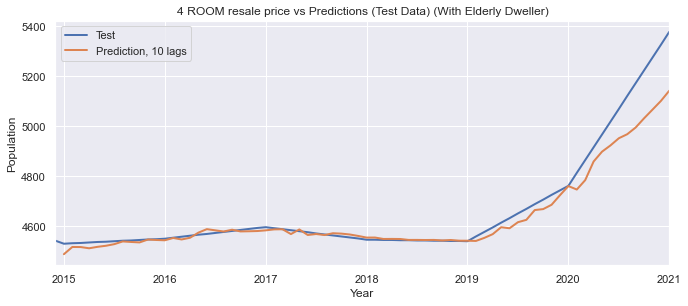

test_error:  32.96406604278888


In [76]:
# adding Elder dweller data as independent param
target = '4 ROOM'
d = data[[x for x in data.columns.to_list() if 'Elderly_' in x]]
metric, predictions = backtrackingForecast(
    target, exog=d, features='With Elderly Dweller')


Forecaster will be fit 73 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



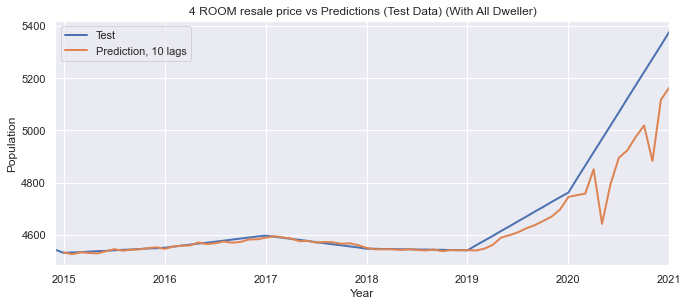

test_error:  41.31121088177434


In [77]:
# adding all dweller data as independent param
target = '4 ROOM'
d = data[[x for x in data.columns.to_list() if '_' in x]]
metric, predictions = backtrackingForecast(
    target, exog=d, features='With All Dweller')


Forecaster will be fit 73 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



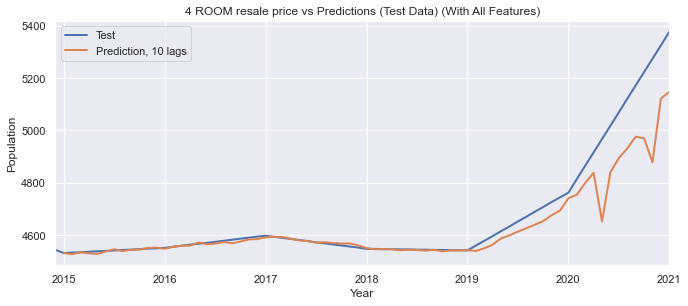

test_error:  40.76035136638567


In [80]:
# adding all data as independent param
target = '4 ROOM'
d = data.loc[:, 'Total Population (Number)':]
metric, predictions = backtrackingForecast(
    target, exog=d, features='With All Features')


NameError: name 'data' is not defined

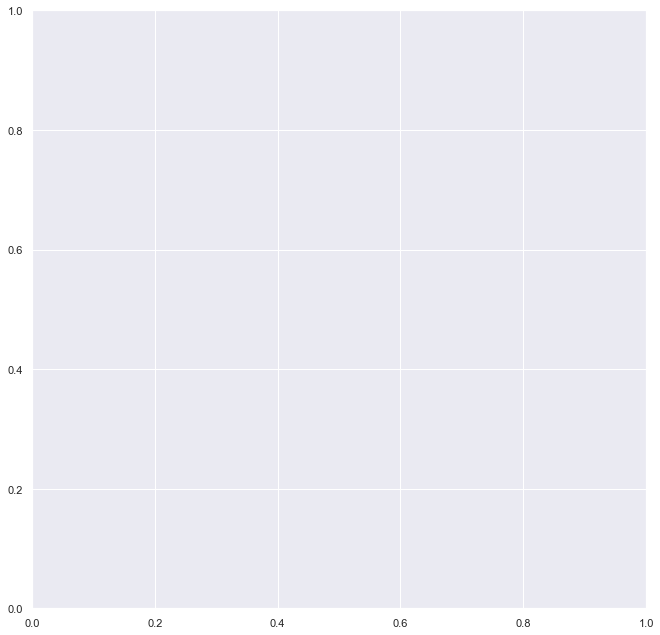

In [26]:
# Plot all the predictions on a single graph
fig, ax = plt.subplots(figsize=(11, 11))
x=data[target]
x.loc[end_train:].plot(ax=ax, linewidth=2, label='Test')

for k,v in result.items():
    predictions = result[k][1]

    predictions.columns = [f'Prediction, {k}']
    predictions.plot(ax=ax, linewidth=2)

ax.set_title(
    f'{target} resale price vs Predictions (Test Data)')
ax.set_ylabel('Population')
ax.set_xlabel('Year')
ax.legend()
plt.show()


In [82]:
errordf = pd.DataFrame({'Features':[x for x in result.keys()], 'test_error':[x[0] for x in result.values()]}).sort_values('test_error')
errordf

,Features,test_error
3,With Children Dweller,30.823260
5,With Elderly Dweller,32.964066
1,With Population Numbers,33.751512
0,No Variable,38.769750
2,With Population Density (Total Population Per ...,38.769750
7,With All Features,40.760351
6,With All Dweller,41.311211
4,With Adult Dweller,50.973075


In [85]:
data.shape

(253, 37)